## Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [2]:
data = pd.read_csv('stud_math.csv')

## 1. Первичная обработка

In [3]:
data.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


В колонке Fedu выброс. Колонку studytime, granular преобразовать данные. В колонке famrel выброс. В колонке absences возможно выбросы.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Только колонки school, sex, age не имеют пропусков.

Номинативные: school, sex, adress, famsize, Pstatus, Mjob, Fjob, reason, guardian, schoolsup, famsap, paid, activities, nursery, higher, internet, romantic.

Числовые: age, Medu, Fedu, traveltime, stuytime, failures, studytime, studytimegranular, famrel, freetime, goout, health, absences, score.

Выявим нулевые и пропущеные строки в score.

In [5]:
data.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  nan,  20.])

In [6]:
data.score.isnull().value_counts()

False    389
True       6
Name: score, dtype: int64

Шесть пропущенных значений, удалим эти строки.

In [7]:
workdata = data[data.score.notnull()].copy()
workdata = workdata.reset_index()
workdata.drop(['index'], inplace = True, axis = 1)

In [8]:
workdata.score.unique()

array([ 30.,  50.,  75.,  55.,  95.,  45.,  60.,  70.,  80.,  25.,  40.,
        85.,  90.,  65., 100.,  35.,   0.,  20.])

Посмотрим на значения score, равные нулю.

In [9]:
workdata.score[workdata.score == 0].count()

37

In [10]:
workdata[workdata.score == 0]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,-3.0,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,-9.0,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,-6.0,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,NaN,no,yes,-6.0,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,-12.0,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,-3.0,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,-6.0,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


Строк, где score равен нулю достаточно много. Возможно это действительно ученики, не сдавшие экзамен. Оставим эти значения, так как данных в целом не много.

Определяем процент пропущенных знанчений.

In [11]:
workdata.isnull().sum()/len(workdata)*100

school                  0.000000
sex                     0.000000
age                     0.000000
address                 3.856041
famsize                 6.940874
Pstatus                11.568123
Medu                    0.771208
Fedu                    6.169666
Mjob                    4.884319
Fjob                    9.254499
reason                  4.370180
guardian                7.969152
traveltime              7.197943
studytime               1.799486
failures                5.655527
schoolsup               2.313625
famsup                  9.768638
paid                   10.025707
activities              3.598972
nursery                 3.856041
studytime, granular     1.799486
higher                  5.141388
internet                8.740360
romantic                7.969152
famrel                  6.940874
freetime                2.313625
goout                   1.799486
health                  3.856041
absences                2.827763
score                   0.000000
dtype: flo

Количество пропусков в колонках не более 11%. Удалять эти колонки не будем. Надо решить, заполнить их средним, мединой или модой.

Заменим пропуски модой.

In [12]:
workdata = workdata.fillna(workdata.mode().loc[0])

In [13]:
workdata.isnull().sum()

school                 0
sex                    0
age                    0
address                0
famsize                0
Pstatus                0
Medu                   0
Fedu                   0
Mjob                   0
Fjob                   0
reason                 0
guardian               0
traveltime             0
studytime              0
failures               0
schoolsup              0
famsup                 0
paid                   0
activities             0
nursery                0
studytime, granular    0
higher                 0
internet               0
romantic               0
famrel                 0
freetime               0
goout                  0
health                 0
absences               0
score                  0
dtype: int64

## 2. Анализ распределения числовых переменных

Построим гистограммы распределения для этих переменных и посмотрим их общие статичтические данные.

In [14]:
def histplot(column):
    fig = plt.figure()
    axes = fig.add_axes([0, 0, 1, 1])
    plt.title(column)
    axes.hist(workdata[column], bins = 4)

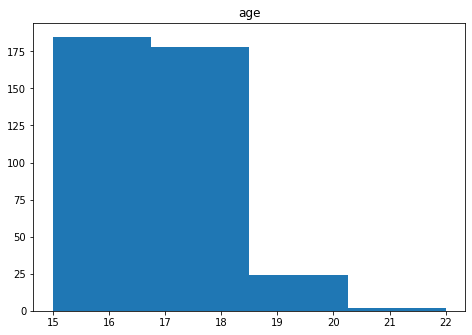

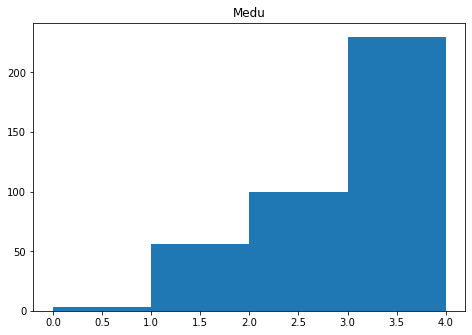

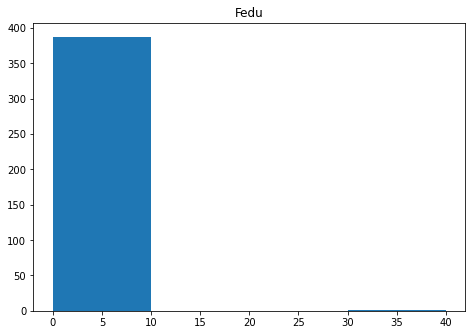

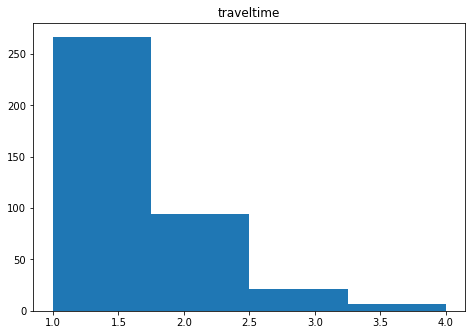

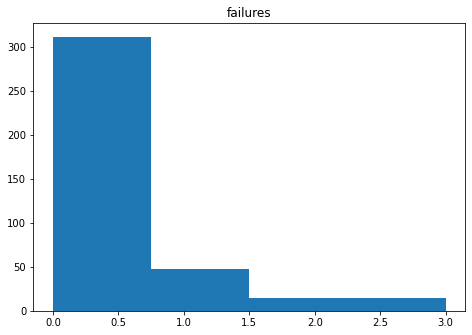

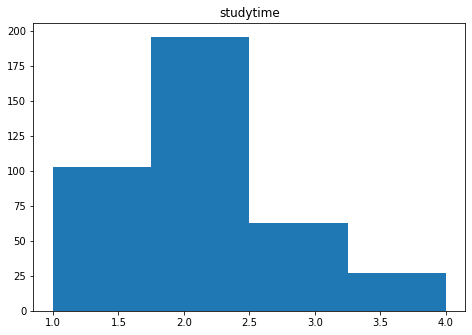

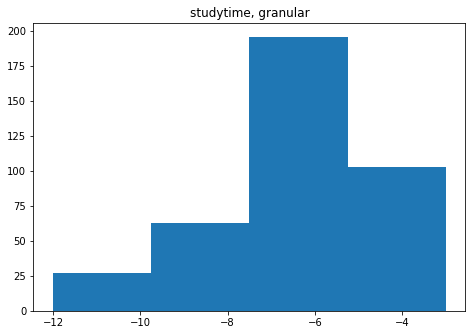

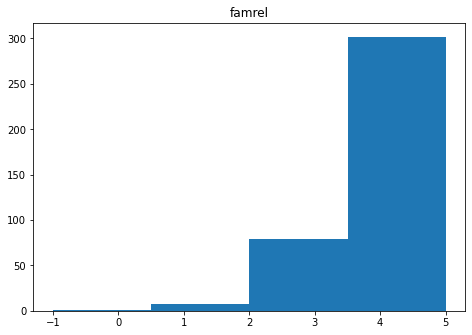

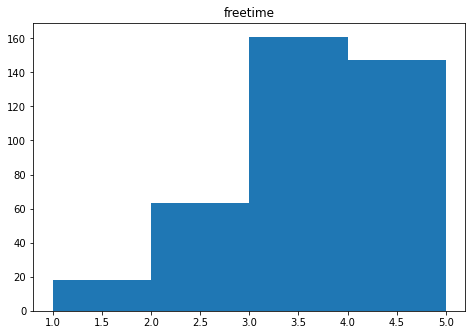

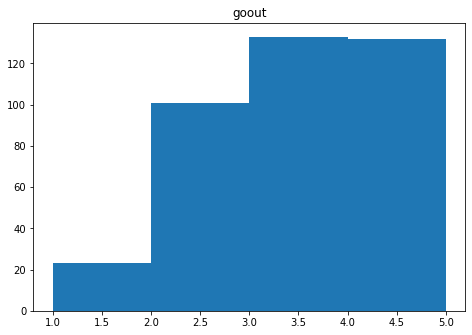

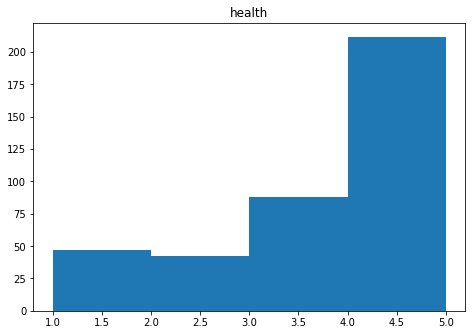

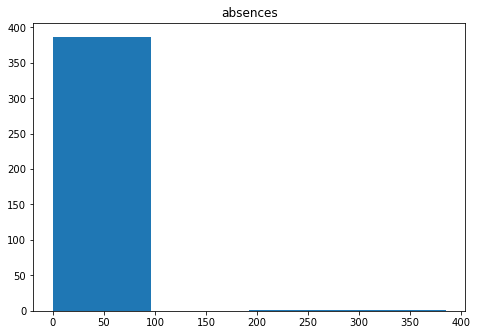

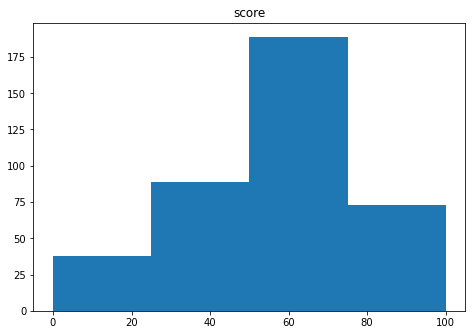

In [15]:
for col in (
    ['age', 'Medu', 'Fedu', 'traveltime', 
     'failures', 'studytime', 'studytime, granular', 
     'famrel', 'freetime', 'goout', 'health', 'absences', 'score']
):
    histplot(col)

In [16]:
workdata.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,16.673522,2.776350,2.588689,1.403599,2.035990,0.308483,-6.107969,3.935733,3.218509,3.092545,3.586118,7.113111,52.262211
std,1.265662,1.095377,2.176604,0.676625,0.839575,0.712521,2.518726,0.898730,0.982353,1.106062,1.403572,23.310047,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,4.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


Как и первичном осмотре видно, что в колонке Fedu выброс. В колонке famrel выброс. В колонке absences возможно выбросы.

В Fedu видимо лишний ноль, заменим его на на 4, в famrel видимо лишний минус, заменим значение на 1. absences надо изучить дополнительно.

In [17]:
workdata[workdata.Fedu == 40]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,T,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


In [18]:
workdata.Fedu.iloc[11] = 4.0

C:\Users\negat\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [19]:
workdata[workdata.famrel == -1]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,T,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


In [20]:
workdata.famrel.iloc[25] = 1.0

C:\Users\negat\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Анализируем экстремальные значения absences.

<AxesSubplot:xlabel='score', ylabel='absences'>

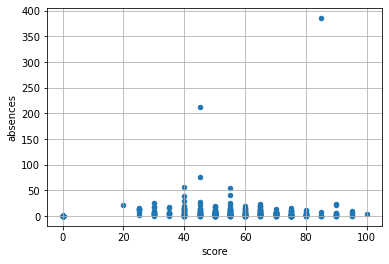

In [21]:
workdata.plot(x='score', y='absences', kind='scatter', grid=True)

Заменим значения более 100 явно выбиваются, так как сделавшие столько пропусков ученики, всеравно не плохо сдали экзамен. Заменим медианой.

In [22]:
workdata.absences = (
    workdata.absences.apply(lambda x: workdata.absences.median() 
                            if x > 100 else x)
)

## 3. Анализ уникальных значений для номинативных переменных

In [23]:
def uniq(column):
    print(column, workdata[column].unique())
    
    
for col in (
    ['school', 'sex', 'address', 'famsize', 'Pstatus', 
     'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 
     'famsup', 'paid', 'activities', 'nursery', 'higher', 
     'internet', 'romantic']
):
    uniq(col)

school ['GP' 'MS']
sex ['F' 'M']
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'health' 'services' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other']
schoolsup ['yes' 'no']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['yes' 'no']
higher ['yes' 'no']
internet ['yes' 'no']
romantic ['no' 'yes']


Уникальные значения соответсевуют допустимым из условий задания.

## 4. Корреляционный анализ данных числовых

In [24]:
workdata.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.145755,-0.143849,0.076013,-0.018019,0.206279,0.018019,0.056941,0.013994,0.121057,-0.061752,0.165356,-0.155726
Medu,-0.145755,1.000000,0.583292,-0.156090,0.076035,-0.238295,-0.076035,-0.003073,0.040743,0.070310,-0.070420,0.097890,0.200890
Fedu,-0.143849,0.583292,1.000000,-0.107267,0.011723,-0.260794,-0.011723,-0.015492,-0.022669,0.046401,-0.015777,0.025740,0.124829
traveltime,0.076013,-0.156090,-0.107267,1.000000,-0.098226,0.035113,0.098226,-0.029213,-0.016696,0.046390,-0.035336,0.005184,-0.056535
studytime,-0.018019,0.076035,0.011723,-0.098226,1.000000,-0.169399,-1.000000,0.037950,-0.122057,-0.053554,-0.063876,-0.061506,0.114295
failures,0.206279,-0.238295,-0.260794,0.035113,-0.169399,1.000000,0.169399,-0.028517,0.087558,0.101036,0.079030,0.058884,-0.337187
"studytime, granular",0.018019,-0.076035,-0.011723,0.098226,-1.000000,0.169399,1.000000,-0.037950,0.122057,0.053554,0.063876,0.061506,-0.114295
famrel,0.056941,-0.003073,-0.015492,-0.029213,0.037950,-0.028517,-0.037950,1.000000,0.164830,0.069514,0.093256,-0.037710,0.052902
freetime,0.013994,0.040743,-0.022669,-0.016696,-0.122057,0.087558,0.122057,0.164830,1.000000,0.294450,0.067629,-0.071956,0.017481
goout,0.121057,0.070310,0.046401,0.046390,-0.053554,0.101036,0.053554,0.069514,0.294450,1.000000,-0.015108,0.029634,-0.127742


studytime, granular на 100% коррелирует с studytime, оставим одну

In [25]:
workdata.drop(['studytime, granular'], inplace = True, axis = 1)

Medu и Fedu заметно коррелируют, так как у нас много переменных, оставим тот, который сильнее влияет на score

In [26]:
workdata.drop(['Fedu'], inplace = True, axis = 1)

traveltime, famrel, freetime, health, absences очень слабо влияют на score, удалим их тоже.

In [27]:
workdata.drop(
    ['traveltime', 'famrel', 'freetime', 'health', 'absences'], 
    inplace = True, axis = 1
)

## 5. Анилиз номинативных переменных

Построим графики box-plot для этих переменных.

In [28]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(
        x=column, y='score', 
        data=workdata.loc[workdata.loc
                          [:, column].isin(workdata.loc[:, column].
                                           value_counts().index[:10])],ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

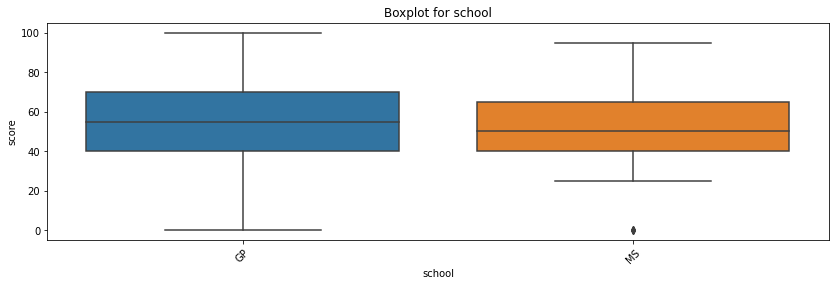

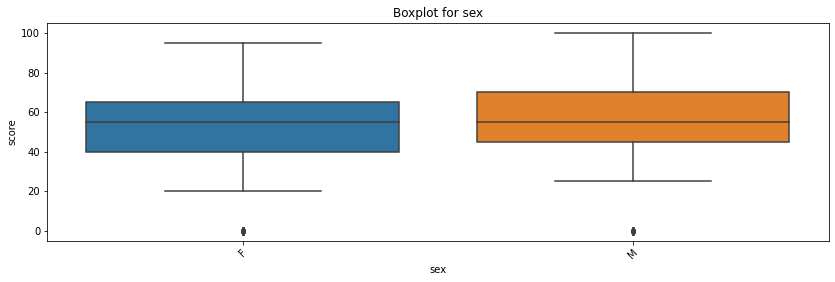

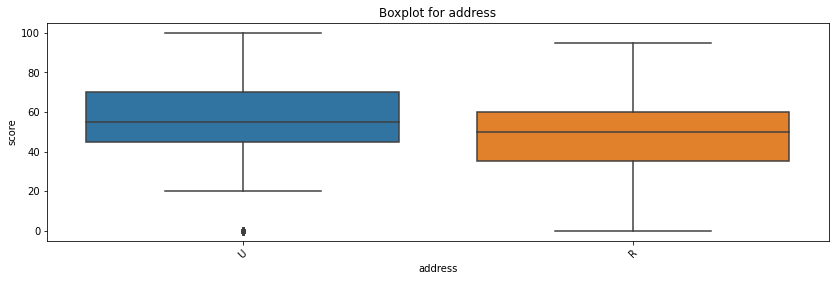

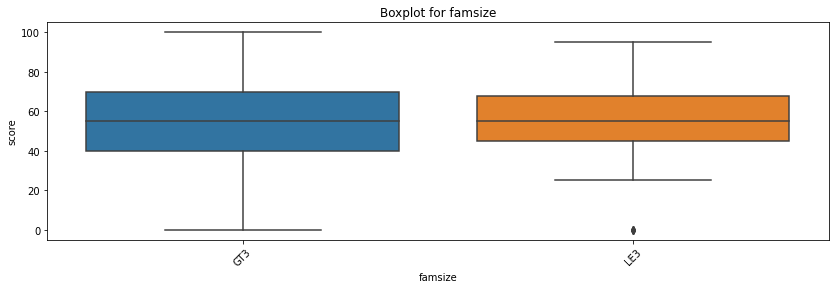

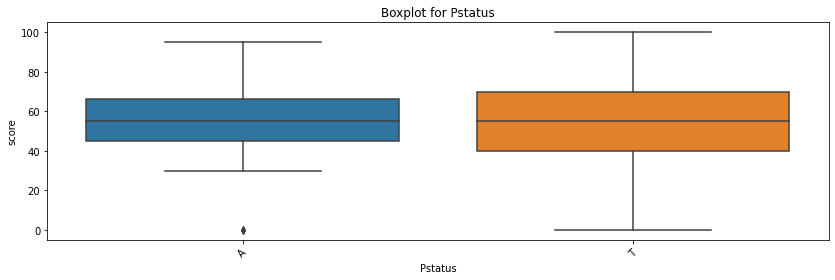

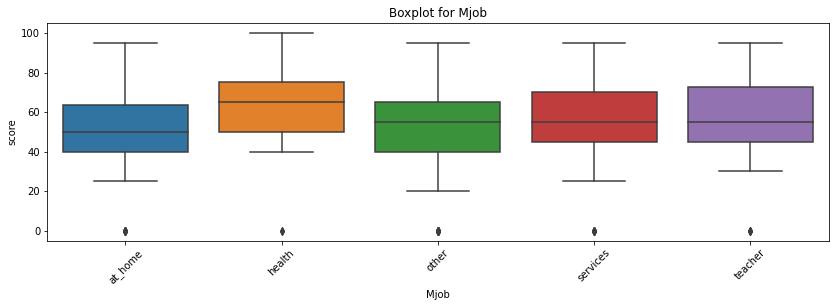

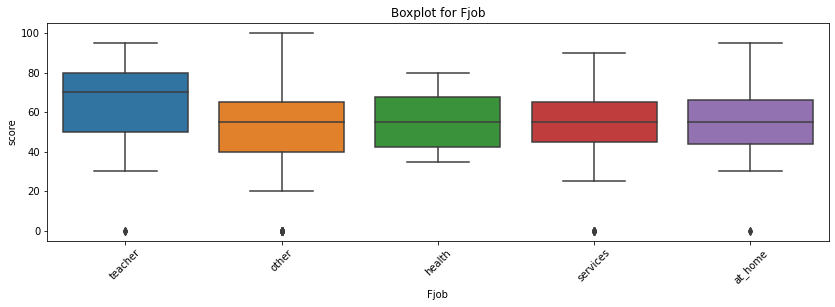

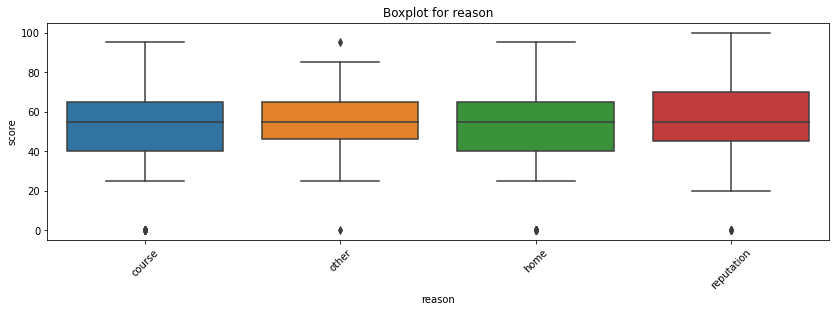

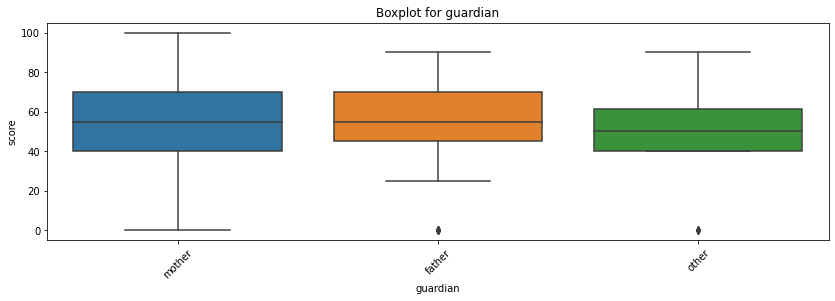

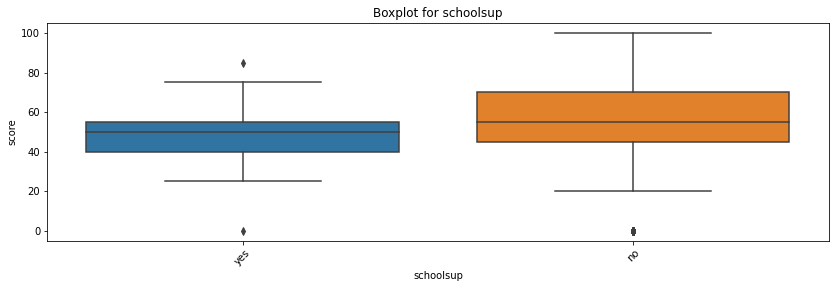

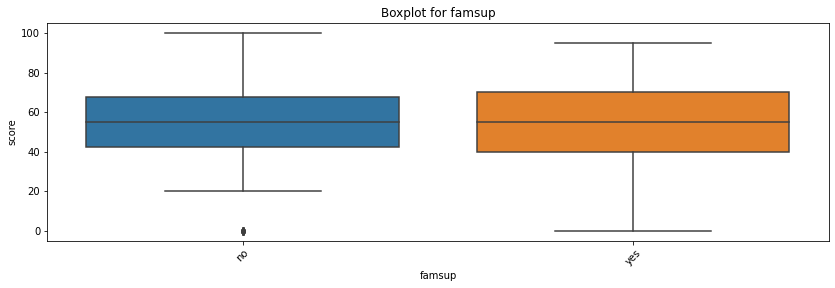

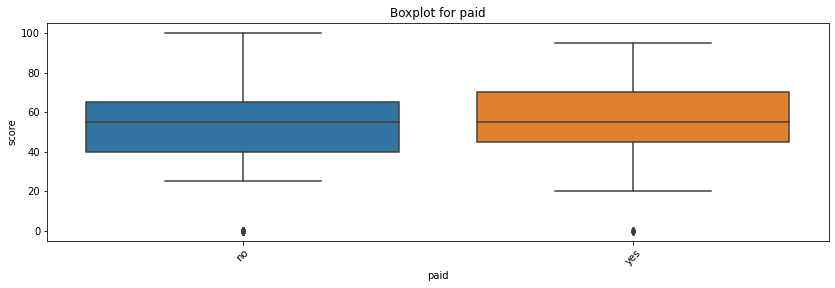

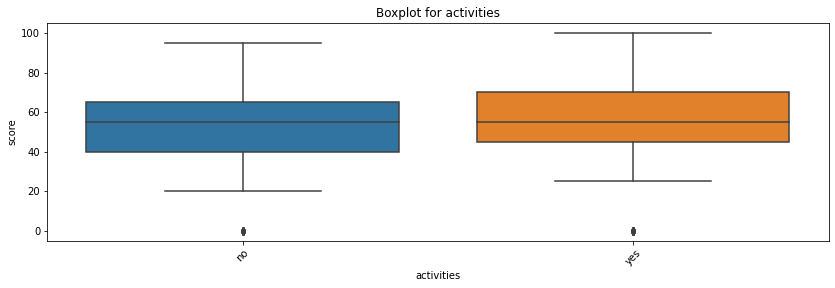

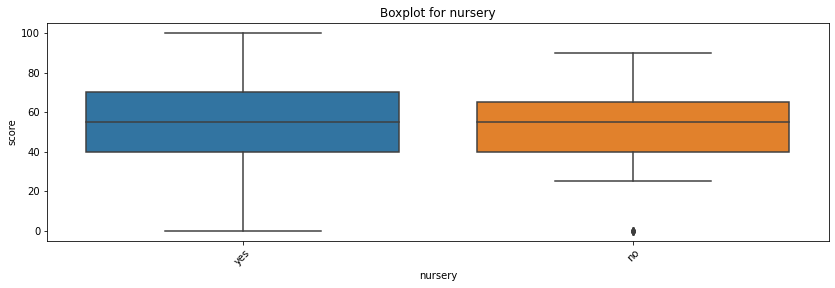

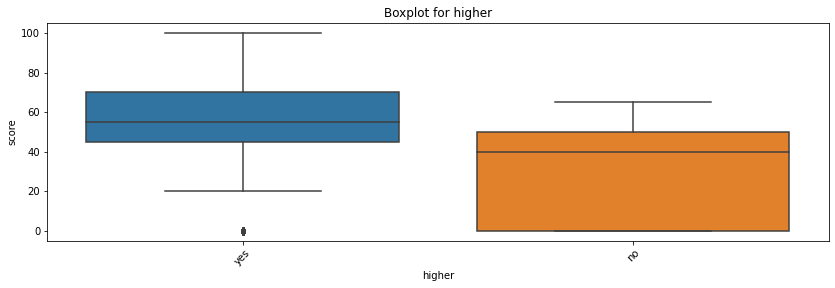

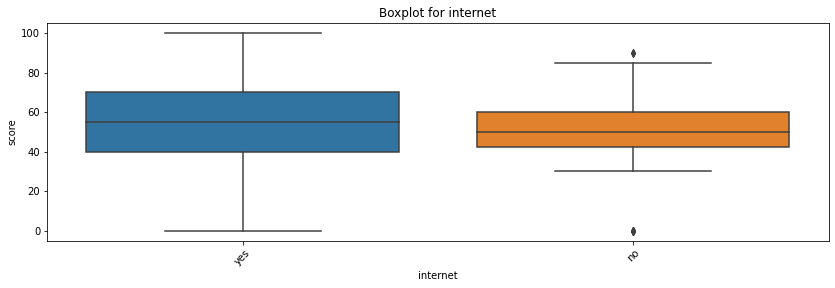

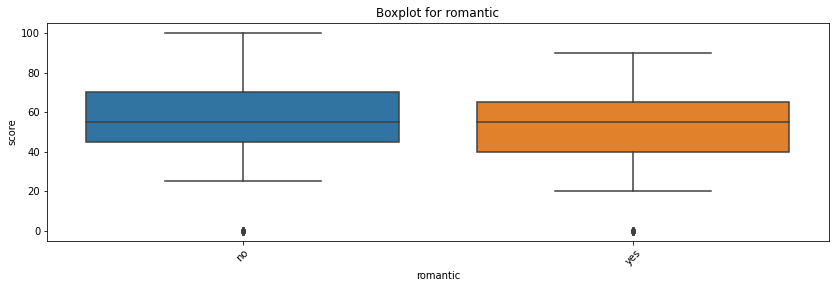

In [29]:
for col in (
    ['school', 'sex', 'address', 'famsize', 
     'Pstatus', 'Mjob', 'Fjob', 'reason', 
     'guardian', 'schoolsup', 'famsup', 'paid', 
     'activities', 'nursery', 'higher', 'internet', 'romantic']
):
    get_boxplot(col)

По графикам видно существенное влияние профессии родителей, места проживания и желания получить высшее образование.

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок батончиков по различным параметрам неразличимы:

In [30]:
def get_stat_dif(column):
    cols = workdata.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(workdata.loc[workdata.loc[:, column] == comb[0], 'score'], 
                        workdata.loc[workdata.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [31]:
for col in (
    ['school', 'sex', 'address', 'famsize', 
     'Pstatus', 'Mjob', 'Fjob', 'reason', 
     'guardian', 'schoolsup', 'famsup', 'paid', 
     'activities', 'nursery', 'higher', 'internet', 'romantic']
):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


Оставим только эти колонки и колонку Fjob, так как на графике заметно отличается, в положительную сторону, результаты детей учителей.

In [32]:
workdata.drop(
    ['school', 'sex', 'famsize', 'Pstatus', 
     'reason', 'guardian', 'schoolsup', 
     'famsup', 'paid', 'activities', 'nursery', 
     'internet'], inplace = True, axis = 1
)

## 6. Преобразование данных

Заменим номинативные переменные числами, для удобства в дальнейшей работе.

In [33]:
def replace_nom(column):
    workdata[column] = workdata[column].apply(
        lambda x: 0 if x == 'at_home'
        else 1 if x == 'teacher'
        else 2 if x == 'health'
        else 3 if x == 'services'
        else 4 if x == 'other'
        else 1 if x == 'U'
        else 2 if x == 'R'
        else 0 if x == 'no'
        else 1 if x == 'yes'
        else x
    )

In [34]:
for col in workdata:
    replace_nom(col)

In [35]:
workdata

,age,address,Medu,Mjob,Fjob,studytime,failures,higher,romantic,goout,score
0,18,1,4.0,0,1,2.0,0.0,1,0,4.0,30.0
1,17,1,1.0,0,4,2.0,0.0,1,0,3.0,30.0
2,15,1,1.0,0,4,2.0,3.0,1,0,2.0,50.0
3,15,1,4.0,2,4,3.0,0.0,1,1,2.0,75.0
4,16,1,3.0,4,4,2.0,0.0,1,0,2.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...
384,20,1,2.0,3,3,2.0,2.0,1,0,4.0,45.0
385,17,1,3.0,3,3,1.0,0.0,1,0,5.0,80.0
386,21,2,1.0,4,4,1.0,3.0,1,0,3.0,35.0
387,18,2,3.0,3,4,1.0,0.0,1,0,1.0,50.0


Преобразуем все числовые переменные float в integer, кроме score.

In [36]:
def integ(column):
    workdata[column] = workdata[column].astype(int)


for col in ['Medu', 'studytime', 'failures', 'goout']:
    integ(col)

In [37]:
workdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        389 non-null    int64  
 1   address    389 non-null    int64  
 2   Medu       389 non-null    int32  
 3   Mjob       389 non-null    int64  
 4   Fjob       389 non-null    int64  
 5   studytime  389 non-null    int32  
 6   failures   389 non-null    int32  
 7   higher     389 non-null    int64  
 8   romantic   389 non-null    int64  
 9   goout      389 non-null    int32  
 10  score      389 non-null    float64
dtypes: float64(1), int32(4), int64(6)
memory usage: 27.5 KB


## 7. Выводы
В результате EDA для анализа влияния уловий жизни учащихся на их успеваемость по математике были получены следующие выводы:
* В данных не более 11% пустых значений.
* Выбросы найдены только в столбцах Fedu, famrel и absences.
* Из графиков boxplot видно сильное влияние желания получить высшее образование, место проживания и профессия родителей на реузльтаты по математике. А из корреляционного анализа числовых переменных видно сильное обратное влияние количества внеучебных неудач.
* Самые важные параметры, которые мы оставим для дальнейшего посторения модели age, address, Medu, Mjob, Fjob, studytime, failures, higher, romantic, goout.